# Data reclassification

Reclassifying data based on specific criteria is a common task when doing GIS analysis. The purpose of this lesson is to see how we can reclassify values based on some criteria. We could, for example, classify information based on travel times and housing prices using these criteria:

```
1. if travel time to my work is less than 30 minutes

    AND

    2. the rent of the apartment is less than 1000 € per month

    ------------------------------------------------------

    IF TRUE: ==> I go to view it and try to rent the apartment
    IF NOT TRUE: ==> I continue looking for something else
```

In this tutorial, we will:

1. Use classification schemes from the PySAL [mapclassify library](https://pysal.org/mapclassify/) to classify travel times into multiple classes.

2. Create a custom classifier to classify travel times and distances in order to find out good locations to buy an apartment with these conditions:
   - good public transport accessibility to city center
   - bit further away from city center where the prices are presumably lower

## Input data

We will use [Travel Time Matrix data from Helsinki](https://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix/) that contains travel time and distance information for 
routes between all 250 m x 250 m grid cell centroids (n = 13231) in the Capital Region of Helsinki by walking, cycling, public transportation and car.

In this tutorial, we will use the geojson file generated in the previous section:
`"data/TravelTimes_to_5975375_RailwayStation_Helsinki.geojson"`

Alternatively, you can re-download [L4 data](https://github.com/AutoGIS/data/raw/master/L4_data.zip) and use `"data/Travel_times_to_5975375_RailwayStation.shp"` as input file in here.



## Common classifiers

### Classification schemes for thematic maps


[PySAL](https://pysal.org/) -module is an extensive Python library for spatial analysis. It also includes all of the most common data classifiers that are used commonly e.g. when visualizing data. Available map classifiers in [pysal's mapclassify -module](https://github.com/pysal/mapclassify):

 - Box_Plot
 - Equal_Interval
 - Fisher_Jenks
 - Fisher_Jenks_Sampled
 - HeadTail_Breaks
 - Jenks_Caspall
 - Jenks_Caspall_Forced
 - Jenks_Caspall_Sampled
 - Max_P_Classifier
 - Maximum_Breaks
 - Natural_Breaks
 - Quantiles
 - Percentiles
 - Std_Mean
 - User_Defined

- First, we need to read our Travel Time data from Helsinki:

In [1]:
import geopandas as gpd

fp = "data/TravelTimes_to_5975375_RailwayStation_Helsinki.geojson"

# Read the GeoJSON file similarly as Shapefile
acc = gpd.read_file(fp)

# Let's see what we have
acc.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
0,29476,41,29483,46,5876274,29990,76,95,24984,77,99,5975375,25532,365,27517366,Helsinki,Helsingfors,091,"POLYGON ((402250.000 6685750.000, 402024.224 6..."
1,29456,41,29462,46,5876275,29866,74,95,24860,75,93,5975375,25408,363,27517366,Helsinki,Helsingfors,091,"POLYGON ((402367.890 6685750.000, 402250.000 6..."
2,36772,50,36778,56,5876278,33541,116,137,44265,130,146,5975375,31110,444,27517366,Helsinki,Helsingfors,091,"POLYGON ((403250.000 6685750.000, 403148.515 6..."
3,36898,49,36904,56,5876279,33720,119,141,44444,132,155,5975375,31289,447,27517366,Helsinki,Helsingfors,091,"POLYGON ((403456.484 6685750.000, 403250.000 6..."
4,29411,40,29418,44,5878128,29944,75,95,24938,76,99,5975375,25486,364,27517366,Helsinki,Helsingfors,091,"POLYGON ((402000.000 6685500.000, 401900.425 6..."


As we can see, there are plenty of different variables (see [from here the description](http://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix-2015) for all attributes) but what we are interested in are columns called `pt_r_tt` which is telling the time in minutes that it takes to reach city center from different parts of the city, and `walk_d` that tells the network distance by roads to reach city center from different parts of the city (almost equal to Euclidian distance).

**The NoData values are presented with value -1**. 

- Thus we need to remove the No Data values first.


In [2]:
# Include only data that is above or equal to 0
acc = acc.loc[acc['pt_r_tt'] >=0]

- Let's plot the data and see how it looks like
- `cmap` parameter defines the color map. Read more about [choosing colormaps in matplotlib](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)
- `scheme` option scales the colors according to a classification scheme (requires `mapclassify` module to be installed):

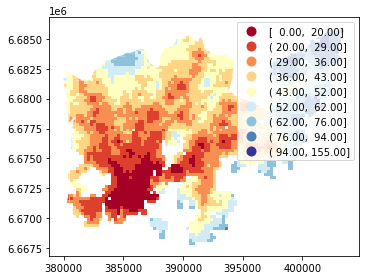

In [3]:
import matplotlib.pyplot as plt

# Plot using 9 classes and classify the values using "Natural Breaks" classification
acc.plot(column="pt_r_tt", scheme="Natural_Breaks", k=9, cmap="RdYlBu", linewidth=0, legend=True)

# Use tight layout
plt.tight_layout()

As we can see from this map, the travel times are lower in the south where the city center is located but there are some areas of "good" accessibility also in some other areas (where the color is red).

- Let's also make a plot about walking distances:

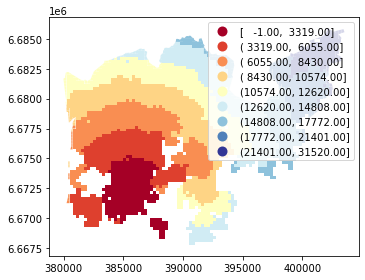

In [4]:
# Plot walking distance
acc.plot(column="walk_d", scheme="Natural_Breaks", k=9, cmap="RdYlBu", linewidth=0, legend=True)

# Use tight layour
plt.tight_layout()

Okay, from here we can see that the walking distances (along road network) reminds more or less Euclidian distances. 

### Applying classifiers to data

As mentioned, the `scheme` option defines the classification scheme using `pysal/mapclassify`. Let's have a closer look at how these classifiers work.

In [5]:
import mapclassify

- Natural Breaks

In [6]:
mapclassify.NaturalBreaks(y=acc['pt_r_tt'], k=9)

NaturalBreaks           

    Interval       Count
------------------------
[  0.00,  19.00] |   196
( 19.00,  28.00] |   437
( 28.00,  36.00] |   809
( 36.00,  43.00] |   835
( 43.00,  53.00] |   688
( 53.00,  65.00] |   423
( 65.00,  78.00] |   202
( 78.00,  95.00] |   163
( 95.00, 155.00] |    54

- Quantiles (default is 5 classes):

In [7]:
mapclassify.Quantiles(y=acc['pt_r_tt'])

Quantiles               

    Interval       Count
------------------------
[  0.00,  30.00] |   792
( 30.00,  37.00] |   779
( 37.00,  44.00] |   821
( 44.00,  56.00] |   685
( 56.00, 155.00] |   730

- It's possible to extract the threshold values into an array:

In [8]:
classifier = mapclassify.NaturalBreaks(y=acc['pt_r_tt'], k=9)
classifier.bins

array([ 22.,  31.,  38.,  44.,  52.,  62.,  76.,  95., 155.])

- Let's apply one of the `Pysal` classifiers into our data and classify the travel times by public transport into 9 classes
- The classifier needs to be initialized first with `make()` function that takes the number of desired classes as input parameter

In [9]:
# Create a Natural Breaks classifier
classifier = mapclassify.NaturalBreaks.make(k=9)

- Now we can apply that classifier into our data by using `apply` -function

In [10]:
# Classify the data
classifications = acc[['pt_r_tt']].apply(classifier)

# Let's see what we have
classifications.head()

,pt_r_tt
0,8
1,7
2,8
3,8
4,8


In [11]:
type(classifications)

pandas.core.frame.DataFrame

Okay, so now we have a DataFrame where our input column was classified into 9 different classes (numbers 1-9) based on [Natural Breaks classification](http://wiki-1-1930356585.us-east-1.elb.amazonaws.com/wiki/index.php/Jenks_Natural_Breaks_Classification).

- We can also add the classification values directly into a new column in our dataframe:

In [12]:
# Rename the column so that we know that it was classified with natural breaks
acc['nb_pt_r_tt'] = acc[['pt_r_tt']].apply(classifier)

# Check the original values and classification
acc[['pt_r_tt', 'nb_pt_r_tt']].head()

,pt_r_tt,nb_pt_r_tt
0,99,8
1,93,7
2,146,8
3,155,8
4,99,8


Great, now we have those values in our accessibility GeoDataFrame. Let's visualize the results and see how they look.

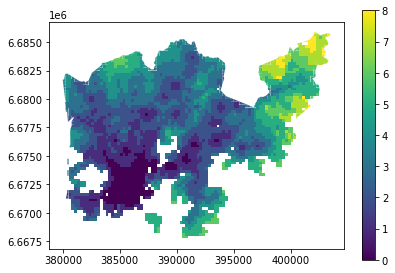

In [13]:
# Plot
acc.plot(column="nb_pt_r_tt", linewidth=0, legend=True)

# Use tight layout
plt.tight_layout()

And here we go, now we have a map where we have used one of the common classifiers to classify our data into 9 classes.

## Plotting a histogram

A histogram is a graphic representation of the distribution of the data. When classifying the data, it's always good to consider how the data is distributed, and how the classification shceme divides values into different ranges. 

- plot the histogram using [pandas.DataFrame.plot.hist](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.hist.html)
- Number of histogram bins (groups of data) can be controlled using the parameter `bins`:

<AxesSubplot:ylabel='Frequency'>

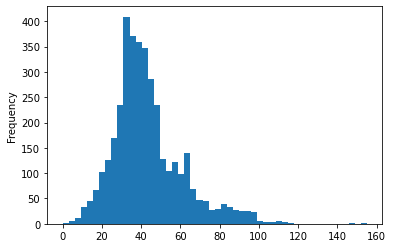

In [14]:
# Histogram for public transport rush hour travel time
acc['pt_r_tt'].plot.hist(bins=50)

Let's also add threshold values on thop of the histogram as vertical lines.

- Natural Breaks:

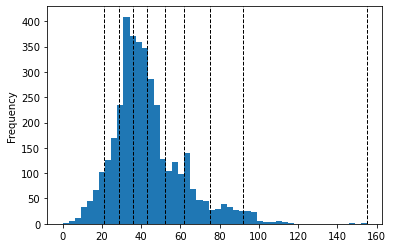

In [15]:
# Define classifier
classifier = mapclassify.NaturalBreaks(y=acc['pt_r_tt'], k=9)

# Plot histogram for public transport rush hour travel time
acc['pt_r_tt'].plot.hist(bins=50)

# Add vertical lines for class breaks
for value in classifier.bins:
    plt.axvline(value, color='k', linestyle='dashed', linewidth=1)

- Quantiles:

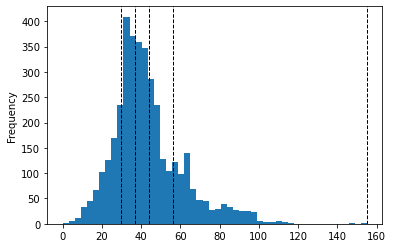

In [16]:
# Define classifier
classifier = mapclassify.Quantiles(y=acc['pt_r_tt'])

# Plot histogram for public transport rush hour travel time
acc['pt_r_tt'].plot.hist(bins=50)

for value in classifier.bins:
    plt.axvline(value, color='k', linestyle='dashed', linewidth=1)


<div class="alert alert-info">

**Check your understanding**

Select another column from the data (for example, travel times by car: `car_r_t`). Do the following visualizations using one of the classification schemes available from [pysal/mapclassify](https://github.com/pysal/mapclassify):
    
- histogram with vertical lines showing the classification bins
- thematic map using the classification scheme


</div>

## Creating a custom classifier

**Multicriteria data classification**

Let's create a function where we classify the geometries into two classes based on a given `threshold` -parameter. If the area of a polygon is lower than the threshold value (average size of the lake), the output column will get a value 0, if it is larger, it will get a value 1. This kind of classification is often called a [binary classification](https://en.wikipedia.org/wiki/Binary_classification).

First we need to create a function for our classification task. This function takes a single row of the GeoDataFrame as input, plus few other parameters that we can use.

It also possible to do classifiers with multiple criteria easily in Pandas/Geopandas by extending the example that we started earlier. Now we will modify our binaryClassifier function a bit so that it classifies the data based on two columns.

- Let's call it `custom_classifier` that does the binary classification based on two treshold values:


In [17]:
def custom_classifier(row, src_col1, src_col2, threshold1, threshold2, output_col):
    """Custom classirifer that can be applied on each row of a pandas dataframe (axis=1).
    
    This function classifies data based on values in two source columns and stores the output value in the output column.
    Output values is 1 if the value in src_col1 is LOWER than the threshold1 value AND the value in src_col2 is HIGHER than the threshold2 value. 
    In all other cases, output value is 0.
    
    Args:
        row: one row of data
        src_col1: source column name associated with threshold1
        src_col2: source column name associated with threshold2
        threshold1: upper threshold value for src_col1
        threshold2: lower threshold value for src_col2
        output_col: output column name

    Returns:
        updated row of data.
    """

    # If condition is true, assign 1 into output column
    if row[src_col1] < threshold1 and row[src_col2] > threshold2:
        row[output_col] = 1
    
    # Else, assign 1 into output column
    else:
        row[output_col] = 0

    # Return the updated row
    return row

Now we have defined the function, and we can start using it.

- Let's do our classification based on two criteria and find out grid cells where the **travel time is lower or equal to 20 minutes** but they are further away **than 4 km (4000 meters) from city center**.

- Let's create an empty column for our classification results called `"suitable_area"`.


In [18]:
# Create column for the classification results
acc["suitable_area"] = None

# Use the function
acc = acc.apply(custom_classifier, 
                src_col1='pt_r_tt', 
                src_col2='walk_d', 
                threshold1=20, 
                threshold2=4000, 
                output_col="suitable_area", 
                axis=1)

# See the first rows
acc.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,...,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry,nb_pt_r_tt,suitable_area
0,29476,41,29483,46,5876274,29990,76,95,24984,77,...,5975375,25532,365,27517366,Helsinki,Helsingfors,091,"POLYGON ((402250.000 6685750.000, 402024.224 6...",8,0
1,29456,41,29462,46,5876275,29866,74,95,24860,75,...,5975375,25408,363,27517366,Helsinki,Helsingfors,091,"POLYGON ((402367.890 6685750.000, 402250.000 6...",7,0
2,36772,50,36778,56,5876278,33541,116,137,44265,130,...,5975375,31110,444,27517366,Helsinki,Helsingfors,091,"POLYGON ((403250.000 6685750.000, 403148.515 6...",8,0
3,36898,49,36904,56,5876279,33720,119,141,44444,132,...,5975375,31289,447,27517366,Helsinki,Helsingfors,091,"POLYGON ((403456.484 6685750.000, 403250.000 6...",8,0
4,29411,40,29418,44,5878128,29944,75,95,24938,76,...,5975375,25486,364,27517366,Helsinki,Helsingfors,091,"POLYGON ((402000.000 6685500.000, 401900.425 6...",8,0


Okey we have new values in `suitable_area` -column.

- How many Polygons are suitable for us? Let's find out by using a Pandas function called `value_counts()` that return the count of different values in our column.


In [19]:
# Get value counts
acc['suitable_area'].value_counts()

0    3798
1       9
Name: suitable_area, dtype: int64

Okay, so there seems to be nine suitable locations for us where we can try to find an appartment to buy.

- Let's see where they are located:


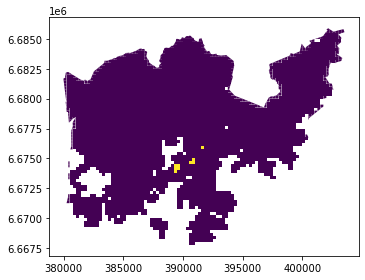

In [20]:
# Plot
acc.plot(column="suitable_area", linewidth=0)

# Use tight layour
plt.tight_layout()

A-haa, okay so we can see that suitable places for us with our criteria seem to be located in the
eastern part from the city center. Actually, those locations are along the metro line which makes them good locations in terms of travel time to city center since metro is really fast travel mode.

**Other examples**

Older course materials contain an example of applying a [custom binary classifier on the Corine land cover data](https://automating-gis-processes.github.io/2017/lessons/L4/reclassify.html#classifying-data>).